In [2]:
import os
import sys
import numpy as np
import pickle
import itertools
from scipy.io.matlab import loadmat
from scipy.spatial.distance import cosine
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
%matplotlib inline

In [9]:
color = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(color)):    
    r, g, b = color[i]    
    color[i] = (r / 255., g / 255., b / 255.)    

line_style = ['--', '-',  '-.', ':']    
model_colors = {'brescal':color[0], 'amdc_pop':color[14], 'amdc_pred':color[7], 'bcomp_mul':color[2], 'bcomp_add':color[3], 'logit':color[5], 'brescal_passive':'k', 'passive':'k'}
model_names = {'brescal':'pnormal-ts', 'amdc_pop':'amdc_pop', 'amdc_pred':'amdc_pred',
               'bcomp_mul':'pcomp-mul-ts', 
               'bcomp_add':'pcomp-add-ts', 'logit':'blogit', 'brescal_passive':'brescal_passive', 'passive':'passive'}    

In [145]:
n_entity = 10
n_relation = 3
n_erelation = n_relation + n_relation**2
n_dim = 10
n_test = 10
n_particle = 5
var_x = var_comp = 0.1
var_e = 1
var_r = 1

E = np.random.normal(0, var_e, size=[n_entity, n_dim])
R = np.random.normal(0, var_r, size=[n_relation, n_dim, n_dim])

T = np.zeros([n_erelation, n_entity, n_entity])
for k in range(n_relation):
    for i in range(n_entity):
        for j in range(n_entity):
            T[k,i,j] = np.dot(np.dot(E[i], R[k]), E[j])

for k, (k1, k2) in enumerate(itertools.product(range(n_relation), repeat=2)):
    for i in range(n_entity):
        for j in range(n_entity):
            T[n_relation + k, i, j] = np.dot(np.dot(E[i], np.dot(R[k1], R[k2])), E[j])
#            T[n_relation + k, i, j] = np.dot(np.dot(E[i], 0.5*R[k1] + 0.5*R[k2]), E[j])            
            

In [146]:
models = ['brescal', 'bcomp_add', 'bcomp_mul', 'passive']
max_iter = n_erelation * n_entity**2
n_test = 10
result = dict()
for model in models:
    result[model] = np.zeros([n_test, max_iter])
    
for nt in range(n_test):
    for model in models:
        if model == 'brescal':
            _model = PFBayesianRescal(n_dim, var_x=var_x, n_particles=n_particle, compute_score=False, parallel=False,
                                      sample_all=True)
            seq = _model.fit(T, obs_mask=np.zeros_like(T), max_iter=max_iter)
            cum_regret = compute_regret(T, seq)
            result[model][nt] = np.cumsum(cum_regret)
        elif model == 'bcomp_add':
            _model = PFBayesianCompRescal(n_dim, compositionality='additive', var_x=var_x, var_comp=var_comp,
                                          n_particles=n_particle, compute_score=False)            
            seq = _model.fit(T[:n_relation], max_iter=max_iter, realT=T)
            cum_regret = compute_regret(T, seq)
            result[model][nt] = np.cumsum(cum_regret)

        elif model == 'bcomp_mul':
            _model = PFBayesianCompRescal(n_dim, compositionality='multiplicative', var_x=var_x, var_comp=var_comp,
                                          n_particles=n_particle, compute_score=False)
            seq = _model.fit(T[:n_relation], max_iter=max_iter, realT=T)
            cum_regret = compute_regret(T, seq)
            result[model][nt] = np.cumsum(cum_regret)

    _seq = [s for s in itertools.product(range(n_relation+n_relation**2), range(n_entity), range(n_entity))]
    np.random.shuffle(_seq)
    result[model][nt] = np.cumsum(compute_regret(T, _seq))
        

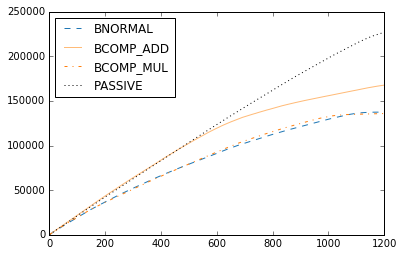

In [147]:
for model in models:
#     if model=='passive':
#         continue
    mean = np.mean(result[model], 0)
    std = np.std(result[model], 0)
    plt.plot(mean, line_style[models.index(model)], label=model_names[model].upper(), color=model_colors[model])
#    plt.fill_between(range(max_iter), mean-std, mean+std, color=model_colors[model], alpha=0.3)
# plt.ylim(0,6000)
plt.legend(loc='upper left')

In [36]:
# import pickle
# pickle.dump([T, n_entity, n_relation, n_dim, result, E, R, var_x, var_e, var_r], open('../result/toy_mul_success.pkl','wb'))

In [132]:
# import pickle
# pickle.dump([T, n_entity, n_relation, n_dim, result, E, R, var_x, var_e, var_r], open('../result/toy_add_success.pkl','wb'))

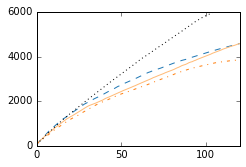

In [96]:
import pickle
plt.figure(figsize=(8,2.4))
plt.sub(1,2,1)
T, n_entity, n_relation, n_dim, result, E, R, var_x, var_e, var_r =pickle.load(open('../result/toy_mul_success.pkl','rb'))
for model in models:
#     if model=='passive':
#         continue
    mean = np.mean(result[model], 0)
    std = np.std(result[model], 0)
    plt.plot(mean, line_style[models.index(model)], label=model_names[model].upper(), color=model_colors[model])
#    plt.fill_between(range(max_iter), mean-std, mean+std, color=model_colors[model], alpha=0.3)
plt.ylim(0,6000)
plt.xlim(0,120)
# plt.legend(loc='upper left', frameon=False)
# plt.setp(plt.gca().get_legend().get_texts(), fontsize='10')
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
# plt.savefig('../paper/images/toy_comp_mul_%d_%d_%d.pdf' % (n_entity,n_relation,n_dim), format='PDF', bbox_inches='tight', pad_inches=0.1)    

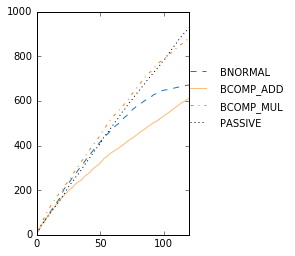

In [97]:
T, n_entity, n_relation, n_dim, result, E, R, var_x, var_e, var_r =pickle.load(open('../result/toy_add_success.pkl','rb'))
# plt.figure(figsize=(3,2.4))
plt.subplot(1,2,2)
for model in models:
#     if model=='passive':
#         continue
    mean = np.mean(result[model], 0)
    std = np.std(result[model], 0)
    plt.plot(mean, line_style[models.index(model)], label=model_names[model].upper(), color=model_colors[model])
#    plt.fill_between(range(max_iter), mean-std, mean+std, color=model_colors[model], alpha=0.3)
# plt.ylim(0,6000)
plt.xlim(0,120)
plt.ylim(0,1000)
#plt.legend(loc='upper left', frameon=False)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), frameon=False)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='10')
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
plt.savefig('../paper/images/toy_comp_add_%d_%d_%d.pdf' % (n_entity,n_relation,n_dim), format='PDF', bbox_inches='tight', pad_inches=0.1)    

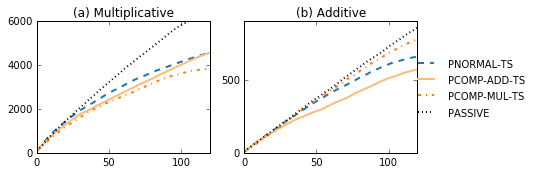

In [10]:
import pickle

models = ['brescal', 'bcomp_add', 'bcomp_mul', 'passive']

plt.figure(figsize=(6,2.5))
plt.subplot(1,2,1)
T, n_entity, n_relation, n_dim, result, E, R, var_x, var_e, var_r =pickle.load(open('../result/toy_mul_success.pkl','rb'))
max_iter = (n_relation + n_relation**2) * n_entity**2
for model in models:
#     if model=='passive':
#         continue
    mean = np.mean(result[model], 0)
    std = np.std(result[model], 0)
    plt.plot(mean, line_style[models.index(model)], label=model_names[model].upper(), color=model_colors[model], linewidth=2.0)
#     plt.fill_between(range(max_iter), mean-std, mean+std, color=model_colors[model], alpha=0.3)
plt.ylim(0,6000)
plt.xlim(0,120)
# plt.legend(loc='upper left', frameon=False)
# plt.setp(plt.gca().get_legend().get_texts(), fontsize='10')
plt.locator_params(axis = 'y', nbins = 4)
plt.locator_params(axis = 'x', nbins = 3)
plt.title('(a) Multiplicative')
T, n_entity, n_relation, n_dim, result, E, R, var_x, var_e, var_r =pickle.load(open('../result/toy_add_success.pkl','rb'))
max_iter = (n_relation + n_relation**2) * n_entity**2
# plt.figure(figsize=(3,2.4))
plt.subplot(1,2,2)
for model in models:
#     if model=='passive':
#         continue
    mean = np.mean(result[model], 0)
    std = np.std(result[model], 0)
    plt.plot(mean, line_style[models.index(model)], label=model_names[model].upper(), color=model_colors[model], linewidth=2.0)
#     plt.fill_between(range(max_iter), mean-std, mean+std, color=model_colors[model], alpha=0.3)
# plt.ylim(0,6000)
plt.xlim(0,120)
plt.ylim(0,900)
#plt.legend(loc='upper left', frameon=False)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), frameon=False)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='10')
plt.locator_params(axis = 'y', nbins = 4)
plt.locator_params(axis = 'x', nbins = 3)
plt.title('(b) Additive')
plt.tight_layout(h_pad=0.3)
plt.savefig('../paper/cikm2016/images/toy_comp_%d_%d_%d.pdf' % (n_entity,n_relation,n_dim), format='PDF', bbox_inches='tight', pad_inches=0.1)    